# Tree based Modelling

6. Decision Tree 
7. Ada Boost
8. Gradient Boosting 
9. XGBoost
10. Random Forest
11. Extra Trees

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate

import plotly.offline as py
import plotly.graph_objs as go

In [105]:
X_train = pd.read_csv('../data/modelling/train/X_train.csv')
y_train = pd.read_csv('../data/modelling/train/y_train.csv')
y_train = y_train['match']
train = pd.concat([X_train, y_train], axis=1)

downsampled_train = pd.read_csv('../data/modelling/train/downsampled_train.csv')
upsampled_train = pd.read_csv('../data/modelling/train/upsampled_train.csv')
oversampled_train = pd.read_csv('../data/modelling/train/oversampled_sm_train.csv')

columns = list(upsampled_train.columns)
columns.remove('match')
X_train_downsampled = downsampled_train[columns]
y_train_downsampled = downsampled_train['match']
X_train_upsampled = upsampled_train[columns]
y_train_upsampled = upsampled_train['match']
X_train_oversampled_sm = oversampled_train[columns]
y_train_oversampled_sm = oversampled_train['match']

X_test= pd.read_csv('../data/modelling/test/X_test.csv')
y_test = pd.read_csv('../data/modelling/test/y_test.csv')
y_test = y_test['match']

X_val = pd.read_csv('../data/modelling/validation/X_val.csv')
y_val = pd.read_csv('../data/modelling/validation/y_val.csv')
y_val = y_val['match']

### Baseline models

In [106]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc  # scoring metrics

def train_classifier_ensemble_CV(classifiers, X_data, y_data, clf_params=None, cv_splits=10, 
                                 random_state=27, return_trained_classifiers=False, verbose=0):

    # initialization
    kfold = StratifiedKFold(n_splits=cv_splits, random_state=12,shuffle=True)
    
    train_accuracy_mean = []
    train_accuracy_std = []
    test_accuracy_mean = []
    test_accuracy_std = []
    f1_score_mean = []
    f1_score_std = []
    mean_feature_importances = []
    trained_classifiers = []
    classifier_name = []
    
    if clf_params is None:  # construct using classifier's existing parameter assignment
        clf_params = []
        for clf in classifiers:
            params = clf.get_params() 
            if 'random_state' in params.keys():  # assign random state / seed
                params['random_state'] = random_state
            elif 'seed' in params.keys():
                params['seed'] = random_state
            clf_params.append(params)
    
    # step through the classifiers for training and scoring with cross-validation
    for clf, params in zip(classifiers, clf_params):
        
        # automatically obtain the name of the classifier
        name = get_clf_name(clf)
        classifier_name.append(name)
        
        if verbose == 1:  # print status
            print('\nPerforming Cross-Validation on Classifier %s of %s:' 
                  % (len(classifier_name), len(classifiers)))
            print(name)
        
        # perform k-fold cross validation for this classifier and calculate scores for each split
        kth_train_accuracy = []
        kth_test_accuracy = []
        kth_test_f1_score = []
        kth_feature_importances = []
        
        for (train, test) in kfold.split(X_data, y_data):
        
            clf.set_params(**params)
            clf.fit(X_data.iloc[train], y_data.iloc[train])
            
            kth_train_accuracy.append(clf.score(X_data.iloc[train], y_data.iloc[train]))
            kth_test_accuracy.append(clf.score(X_data.iloc[test], y_data.iloc[test]))
            kth_test_f1_score.append(f1_score(y_true=y_data.iloc[test], y_pred=clf.predict(X_data.iloc[test])))
            
            if hasattr(clf, 'feature_importances_'):  # some classifiers (like linReg) lack this attribute
                kth_feature_importances.append(clf.feature_importances_)
        
        # populate scoring statistics for this classifier (over all cross-validation splits)
        train_accuracy_mean.append(np.mean(kth_train_accuracy))
        train_accuracy_std.append(np.std(kth_train_accuracy))
        test_accuracy_mean.append(np.mean(kth_test_accuracy))
        test_accuracy_std.append(np.std(kth_test_accuracy))
        f1_score_mean.append(np.mean(kth_test_f1_score))
        f1_score_std.append(np.std(kth_test_f1_score))
    
        # obtain array of mean feature importances, if this classifier had that attribute
        if len(kth_feature_importances) == 0:
            mean_feature_importances.append(False)
        else:
            mean_feature_importances.append(np.mean(kth_feature_importances, axis=0))
        
        # if requested, also export classifier after fitting on the complete training set 
        if return_trained_classifiers is not False:
            clf.fit(X_data, y_data)
            trained_classifiers.append(clf)
            
        # remove AdaBoost feature importances (we won't discuss their interpretation)
        if type(clf) == type(AdaBoostClassifier()):
            mean_feature_importances[-1] = False
        
    
    # construct dataframe for comparison of classifiers
    clf_comparison = pd.DataFrame({'Classifier Name' : classifier_name, 
                                   'Mean Train Accuracy' : train_accuracy_mean, 
                                   'Train Accuracy Standard Deviation' : train_accuracy_std,
                                   'Mean Test Accuracy' : test_accuracy_mean, 
                                   'Test Accuracy Standard Deviation' : test_accuracy_std, 
                                   'Mean Test F1-Score' : f1_score_mean,
                                   'F1-Score Standard Deviation' : f1_score_std})
    
    # enforce the desired column order
    clf_comparison = clf_comparison[['Classifier Name', 'Mean Train Accuracy',
                                     'Train Accuracy Standard Deviation', 'Mean Test Accuracy',
                                     'Test Accuracy Standard Deviation', 'Mean Test F1-Score',
                                     'F1-Score Standard Deviation']]
                   
    
    # add return_trained_classifiers to the function return, if requested, otherwise omit                                                
    if return_trained_classifiers is not False:
        return clf_comparison, mean_feature_importances, trained_classifiers
    else:
        return clf_comparison, mean_feature_importances

def get_clf_name(classifier_object):
    name_ = str(type(classifier_object)).split('.')[-1]
    for char in """ "'>() """:  # triple-quoted string definition allows us to include " and ' as characters
        name_ = name_.replace(char,"")  # delete unwanted characters from the name
    
    return name_

In [107]:

classifier_list = [DecisionTreeClassifier(), 
                   AdaBoostClassifier(), 
                   GradientBoostingClassifier(), 
                   XGBClassifier(), 
                   RandomForestClassifier(),
                   ExtraTreesClassifier()]

In [108]:
clf_comp_Full_FeatureSet, mean_feature_importances = train_classifier_ensemble_CV(classifiers=classifier_list, 
                                                                                 X_data=X_train, 
                                                                                 y_data=y_train)

clf_comp_Full_FeatureSet_downsampled, mean_feature_importances_downsampled = train_classifier_ensemble_CV(classifiers=classifier_list, 
                                                                                 X_data=X_train_downsampled, 
                                                                                 y_data=y_train_downsampled)

clf_comp_Full_FeatureSet_downsampled, mean_feature_importances_upsampled = train_classifier_ensemble_CV(classifiers=classifier_list, 
                                                                                 X_data=X_train_upsampled, 
                                                                                 y_data=y_train_upsampled)

In [109]:
clf_comp_Full_FeatureSet

Classifier Name  Mean Train Accuracy  \
0      DecisionTreeClassifier             1.000000   
1          AdaBoostClassifier             0.859118   
2  GradientBoostingClassifier             0.888816   
3               XGBClassifier             1.000000   
4      RandomForestClassifier             1.000000   
5        ExtraTreesClassifier             1.000000   

   Train Accuracy Standard Deviation  Mean Test Accuracy  \
0                           0.000000            0.783081   
1                           0.002299            0.839365   
2                           0.001712            0.860268   
3                           0.000000            0.861090   
4                           0.000000            0.856155   
5                           0.000000            0.854838   

   Test Accuracy Standard Deviation  Mean Test F1-Score  \
0                          0.015018            0.377659   
1                          0.009735            0.440248   
2                          0.010716            0.466962   
3                          0.007735            0.512695   
4                          0.005530            0.351750   
5                          0.007076            0.362963   

   F1-Score Standard Deviation  
0                     0.040639  
1                     0.040483  
2                     0.055552  
3                     0.029466  
4                     0.047332  
5                     0.056091

In [110]:
clf_comp_Full_FeatureSet_downsampled

Classifier Name  Mean Train Accuracy  \
0      DecisionTreeClassifier             1.000000   
1          AdaBoostClassifier             0.792797   
2  GradientBoostingClassifier             0.850933   
3               XGBClassifier             0.999890   
4      RandomForestClassifier             1.000000   
5        ExtraTreesClassifier             1.000000   

   Train Accuracy Standard Deviation  Mean Test Accuracy  \
0                           0.000000            0.933803   
1                           0.003445            0.778876   
2                           0.002853            0.830684   
3                           0.000085            0.954245   
4                           0.000000            0.973202   
5                           0.000000            0.986899   

   Test Accuracy Standard Deviation  Mean Test F1-Score  \
0                          0.006992            0.937580   
1                          0.015044            0.785618   
2                          0.013537            0.837699   
3                          0.007658            0.956067   
4                          0.005334            0.973747   
5                          0.002300            0.986963   

   F1-Score Standard Deviation  
0                     0.006185  
1                     0.014199  
2                     0.012576  
3                     0.007070  
4                     0.005144  
5                     0.002272

In [111]:
clf_comp_Full_FeatureSet_downsampled

Classifier Name  Mean Train Accuracy  \
0      DecisionTreeClassifier             1.000000   
1          AdaBoostClassifier             0.792797   
2  GradientBoostingClassifier             0.850933   
3               XGBClassifier             0.999890   
4      RandomForestClassifier             1.000000   
5        ExtraTreesClassifier             1.000000   

   Train Accuracy Standard Deviation  Mean Test Accuracy  \
0                           0.000000            0.933803   
1                           0.003445            0.778876   
2                           0.002853            0.830684   
3                           0.000085            0.954245   
4                           0.000000            0.973202   
5                           0.000000            0.986899   

   Test Accuracy Standard Deviation  Mean Test F1-Score  \
0                          0.006992            0.937580   
1                          0.015044            0.785618   
2                          0.013537            0.837699   
3                          0.007658            0.956067   
4                          0.005334            0.973747   
5                          0.002300            0.986963   

   F1-Score Standard Deviation  
0                     0.006185  
1                     0.014199  
2                     0.012576  
3                     0.007070  
4                     0.005144  
5                     0.002272

### Feature Importances of our Tree and Ensemble Classifiers
We can examine how some of the classifiers we just trained ranked feature importance:

In [18]:
def plot_mean_feature_importances(clf_comparison, mean_feature_importances, X_data):

    for clf_name, importances in zip(clf_comparison['Classifier Name'], mean_feature_importances):

        if importances is not False:

            indices = np.argsort(importances)[::-1]
            feature_labels = X_data.columns

            plt.figure(figsize=(12,5))
            plt.title('Feature Importances for ' + clf_name)
            plt.bar(range(10), importances[indices][:10], color='lightblue', align='center')
            plt.xticks(range(10), feature_labels[indices][:10], rotation=90)
            plt.xlim([-1, 11])
            plt.tight_layout()
            plt.show()
        
    return

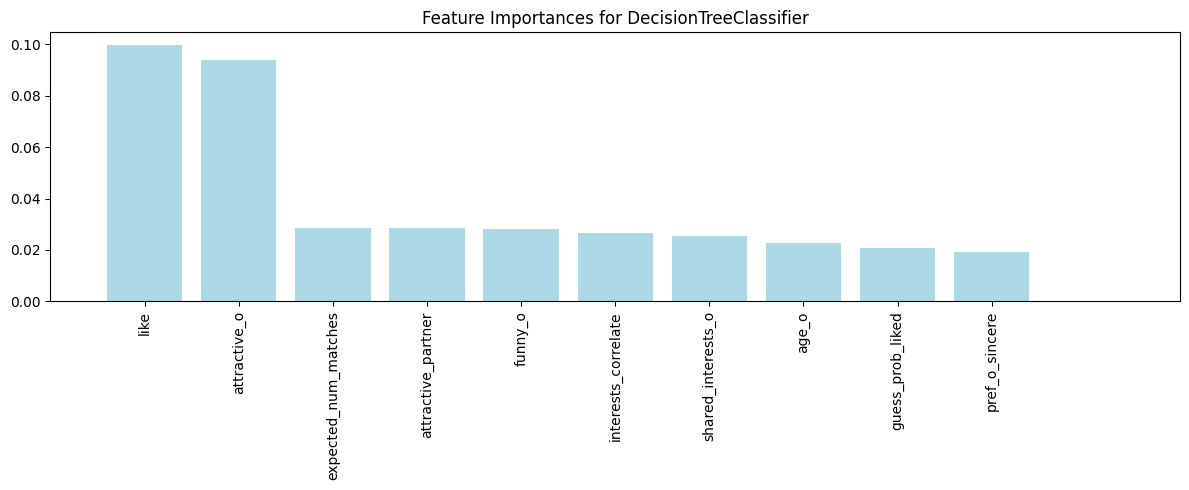

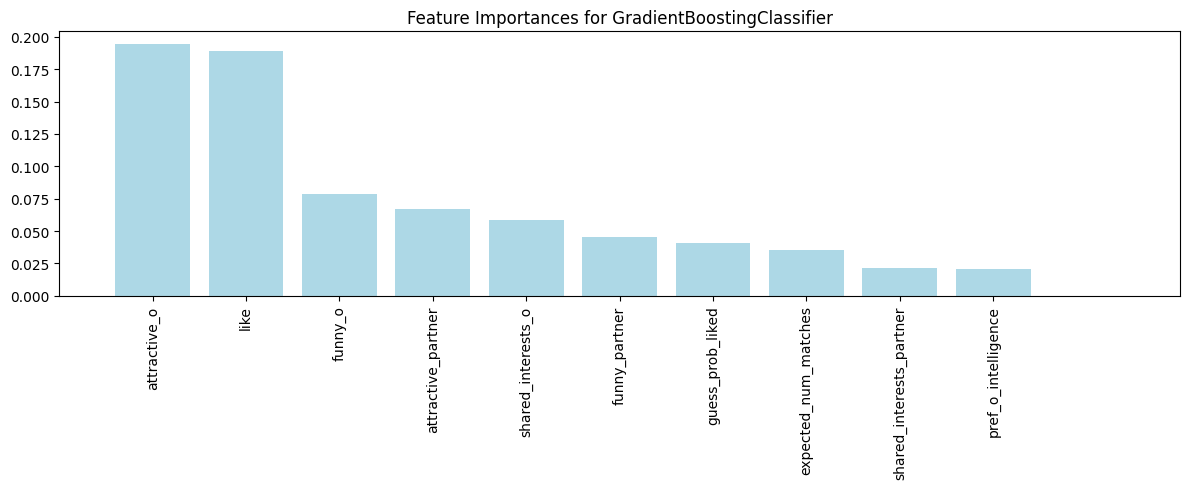

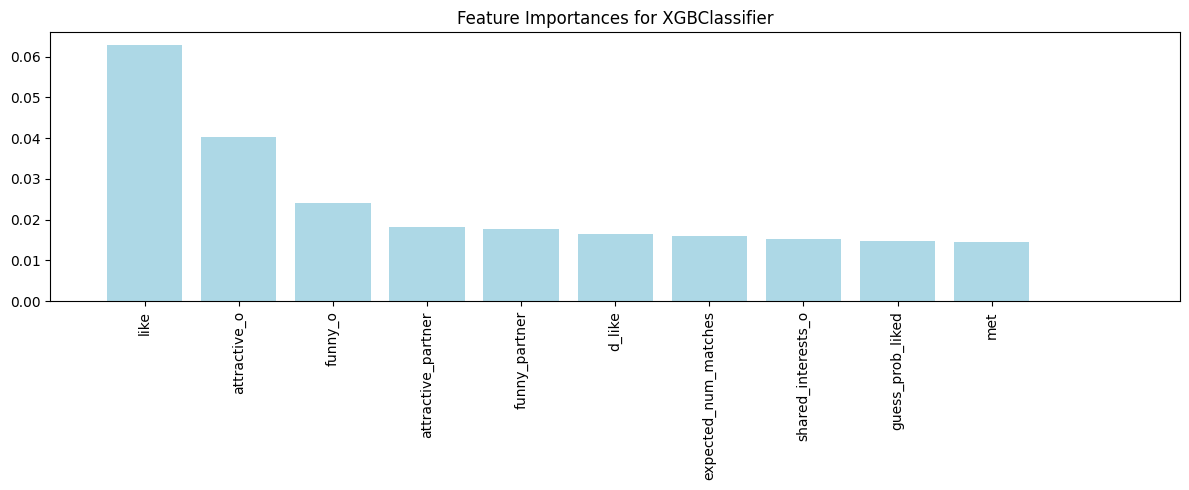

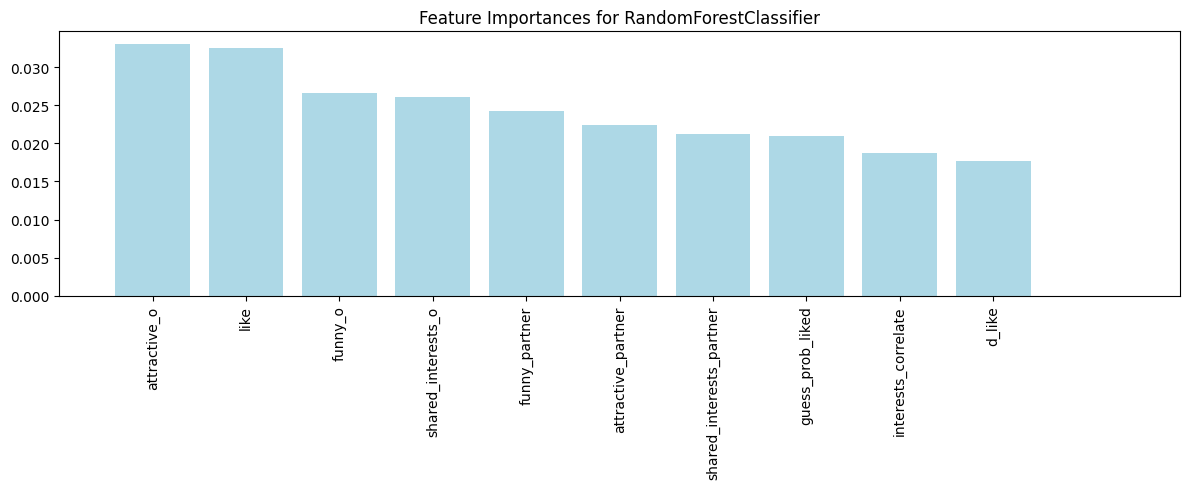

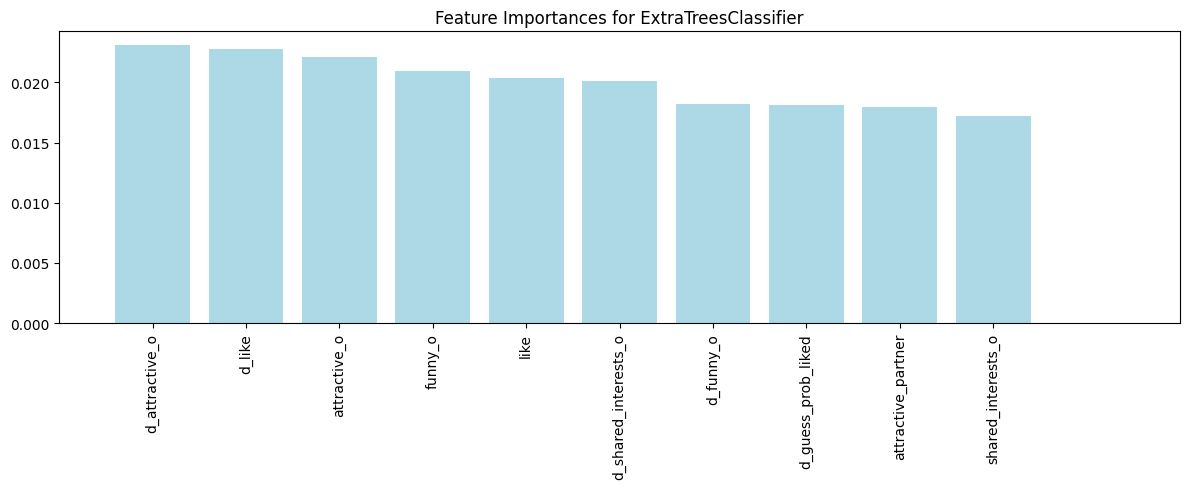

In [19]:
plot_mean_feature_importances(clf_comp_Full_FeatureSet, mean_feature_importances, X_data=X_train)

- <b> Decision tree classifier: </b>

    like, attractive_o, expected_num_matches, attractive_partner, funny_o, interests_correlate, shared_interests_o, age_o, guess_prob_liked, pref_o_sincere

- <b> Gradient boosting classifier:</b>

    atractive_o, like, funny_o, attractive_partner, shared_interests_o, funny_partner, guess_prob_liked, expected_num_matches, shared_interests_partner, pref_o_intelligence

- <b> XGB Classifier:</b>

    like, attractive_o, funny_o, attractive_partner, funny_partner, d_like, expected_num_matches, shared_interests_o, guess_prob_liked, met

- <b> Random Forest classifier:</b>

    attractive_o, like, funny_o, shared_interests_o, funny_partner, attractive_partner, shared_interests_partner, guess_prob_liked, interests_correlate, d_like

- <b> Extra tree classifiers</b>

    d_attractive_o, d_like, attractive_o, funny_o, like, d_shared_interests_o, d_funny_o, d_guess_prob_liked, attractive_partner, shared_interests_o


Findings:


Like, attractive_partner, funny_o, shared_interests_o, guess_prob_liked are the top features for 5/5 of these classifiers. Moreover attractive_o, funny_partner and expected_num_matches also rank highly.


### Algortithm Tuning

In [112]:
columns_d = ['age',
 'age_o',
 'd_age',
 #'d_d_age',
 'samerace',
 'importance_same_race',
 'importance_same_religion',
 #'d_importance_same_race',
 #'d_importance_same_religion',
 'pref_o_attractive',
 'pref_o_sincere',
 'pref_o_intelligence',
 'pref_o_funny',
 'pref_o_ambitious',
 'pref_o_shared_interests',
 #'d_pref_o_attractive',
 #'d_pref_o_sincere',
 #'d_pref_o_intelligence',
 #'d_pref_o_funny',
 #'d_pref_o_ambitious',
 #'d_pref_o_shared_interests',
 'attractive_o',
 'sinsere_o',
 'intelligence_o',
 'funny_o',
 'ambitous_o',
 'shared_interests_o',
 #'d_attractive_o',
 #'d_sinsere_o',
 #'d_intelligence_o',
 #'d_funny_o',
 #'d_ambitous_o',
 #'d_shared_interests_o',
 'attractive_important',
 'sincere_important',
 'intellicence_important',
 'funny_important',
 'ambtition_important',
 'shared_interests_important',
 #'d_attractive_important',
 #'d_sincere_important',
 #'d_intellicence_important',
 #'d_funny_important',
 #'d_ambtition_important',
 #'d_shared_interests_important',
 'attractive',
 'sincere',
 'intelligence',
 'funny',
 'ambition',
 #'d_attractive',
 #'d_sincere',
 #'d_intelligence',
 #'d_funny',
 #'d_ambition',
 'attractive_partner',
 'sincere_partner',
 'intelligence_partner',
 'funny_partner',
 'ambition_partner',
 'shared_interests_partner',
 #'d_attractive_partner',
 #'d_sincere_partner',
 #'d_intelligence_partner',
 #'d_funny_partner',
 #'d_ambition_partner',
 #'d_shared_interests_partner',
 'sports',
 'tvsports',
 'exercise',
 'dining',
 'museums',
 'art',
 'hiking',
 'gaming',
 'clubbing',
 'reading',
 'tv',
 'theater',
 'movies',
 'concerts',
 'music',
 'shopping',
 'yoga',
 #'d_sports',
 #'d_tvsports',
 #'d_exercise',
 #'d_dining',
 #'d_museums',
 #'d_art',
 #'d_hiking',
 #'d_gaming',
 #'d_clubbing',
 #'d_reading',
 #'d_tv',
 #'d_theater',
 #'d_movies',
 #'d_concerts',
 #'d_music',
 #'d_shopping',
 #'d_yoga',
 'interests_correlate',
 #'d_interests_correlate',
 'expected_happy_with_sd_people',
 'expected_num_matches',
 #'d_expected_happy_with_sd_people',
 #'d_expected_num_interested_in_me',
 #'d_expected_num_matches',
 'like',
 'guess_prob_liked',
 #'d_like',
 #'d_guess_prob_liked',
 'met',
 'gender_female',
 'gender_male',
 'race_Asian/Pacific Islander/Asian-American',
 'race_Black/African American',
 'race_European/Caucasian-American',
 'race_Latino/Hispanic American',
 'race_Other',
 'race_o_?',
 'race_o_Asian/Pacific Islander/Asian-American',
 'race_o_Black/African American',
 'race_o_European/Caucasian-American',
 'race_o_Latino/Hispanic American',
 'race_o_Other',
 'field_anthropology',
 'field_architecture',
 'field_art',
 'field_biology',
 'field_business',
 'field_chemistry',
 'field_communications',
 'field_economics',
 'field_education',
 'field_engineering',
 'field_environmental science',
 'field_finance',
 'field_health',
 'field_history',
 'field_law',
 'field_literature',
 'field_mathematics',
 'field_medicine',
 'field_other/job',
 'field_philosophy',
 'field_physics',
 'field_political science',
 'field_psychology',
 'field_religion',
 'field_sociology']

In [113]:
# without categorical variables
X_train_d = X_train[columns_d]
X_train_downsampled_d = X_train_downsampled[columns_d]
X_train_upsampled_d = X_train_upsampled[columns_d]
X_train_oversampled_sm_d = X_train_oversampled_sm[columns_d]
X_test_d = X_test[columns_d]


In [114]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" 
    
        return float(prc.format(f_val))
        
class RandomSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def RandomSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = RandomizedSearchCV(self.model,
                                 self.hyperparameters,
                                 random_state=1,
                                 n_iter=100,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.RandomSearch()
        pred = best_model.predict(X_test)
        return pred

class GridSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def GridSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = GridSearchCV(self.model,
                                 self.hyperparameters,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred

In [115]:
classifier_list = [DecisionTreeClassifier(), 
                   AdaBoostClassifier(), 
                   GradientBoostingClassifier(), 
                   XGBClassifier(), 
                   RandomForestClassifier(),
                   ExtraTreesClassifier()]

In [116]:
models = []
train = []
scores = []

def modeling (model, X_train, y_train, X_test, param_grid, str_model, str_train):
    RandSearch = RandomSearch(X_train,y_train,model,param_grid)
    Prediction_CART = RandSearch.BestModelPridict(X_test)
    score = floatingDecimals((y_test == Prediction_CART).mean(),7)
    models.append(str_model)
    train.append(str_train)
    scores.append(score)

#### 6. Decision Tree 

In [117]:
most_important_variables_dt = ['like', 'attractive_o', 'expected_num_matches', 'attractive_partner', 'funny_o', 'interests_correlate', 
'shared_interests_o', 'age_o', 'guess_prob_liked', 'pref_o_sincere']

# most important features
X_train_imp = X_train[most_important_variables_dt]
X_train_downsampled_imp = X_train_downsampled[most_important_variables_dt]
X_train_upsampled_imp = X_train_upsampled[most_important_variables_dt]
X_train_oversampled_sm_imp = X_train_oversampled_sm[most_important_variables_dt]
X_test_imp = X_test[most_important_variables_dt]

In [118]:
from scipy.stats import randint

max_depth_value = [3,5,7,10,15, None]
max_features_value =  randint(1, 4)
min_samples_leaf_value = [3,5,10,15,20]
criterion_value = ["gini", "entropy"]
min_samples_split_value = [8,10,12,18,20,16]

param_grid = dict(max_depth = max_depth_value,
                  max_features = max_features_value,
                  min_samples_leaf = min_samples_leaf_value,
                  criterion = criterion_value,
                  min_samples_split = min_samples_split_value)

In [119]:

scores = []
models = []
train = []

model_CART = DecisionTreeClassifier()
modeling(model_CART, X_train, y_train, X_test, param_grid, 'DecisionTreeClassifier', 'Original')
modeling(model_CART, X_train_downsampled, y_train_downsampled, X_test, param_grid, 'DecisionTreeClassifier', 'Downsampled')
modeling(model_CART, X_train_upsampled, y_train_upsampled, X_test, param_grid, 'DecisionTreeClassifier', 'Upsampled')
modeling(model_CART, X_train_oversampled_sm, y_train_oversampled_sm, X_test, param_grid, 'DecisionTreeClassifier', 'SMOTE')

scoreDataFrame1 = pd.DataFrame({'Model':models, 'Train': train,'Score': scores})
scoreDataFrame1

Best: 0.830813 using {'criterion': 'gini', 'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 20, 'min_samples_split': 10}
Best: 0.679169 using {'criterion': 'entropy', 'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 15, 'min_samples_split': 16}
Best: 0.840714 using {'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8}
Best: 0.828120 using {'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8}


Model        Train     Score
0  DecisionTreeClassifier     Original  0.843403
1  DecisionTreeClassifier  Downsampled  0.494451
2  DecisionTreeClassifier    Upsampled  0.757090
3  DecisionTreeClassifier        SMOTE  0.790382

In [120]:
scores = []
models = []
train = []

modeling(model_CART, X_train_d, y_train, X_test_d, param_grid, 'DecisionTreeClassifier', 'Original (without d_)')
modeling(model_CART, X_train_downsampled_d, y_train_downsampled, X_test_d, param_grid, 'DecisionTreeClassifier', 'Downsampled (without d_)')
modeling(model_CART, X_train_upsampled_d, y_train_upsampled, X_test_d, param_grid, 'DecisionTreeClassifier', 'Upsampled (without d_)')
modeling(model_CART, X_train_oversampled_sm_d, y_train_oversampled_sm, X_test_d, param_grid, 'DecisionTreeClassifier', 'SMOTE (without d_)')

scoreDataFrame2 = pd.DataFrame({'Model':models, 'Train': train,'Score': scores})
scoreDataFrame2

Best: 0.831304 using {'criterion': 'gini', 'max_depth': 7, 'max_features': 1, 'min_samples_leaf': 5, 'min_samples_split': 20}
Best: 0.669537 using {'criterion': 'gini', 'max_depth': 15, 'max_features': 3, 'min_samples_leaf': 20, 'min_samples_split': 8}
Best: 0.848750 using {'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8}
Best: 0.818200 using {'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8}


Model                     Train     Score
0  DecisionTreeClassifier     Original (without d_)  0.834772
1  DecisionTreeClassifier  Downsampled (without d_)  0.589396
2  DecisionTreeClassifier    Upsampled (without d_)  0.757090
3  DecisionTreeClassifier        SMOTE (without d_)  0.743526

In [121]:
scores = []
models = []
train = []

modeling(model_CART, X_train_imp, y_train, X_test_imp, param_grid, 'DecisionTreeClassifier', 'Original (top10 features)')
modeling(model_CART, X_train_downsampled_imp, y_train_downsampled, X_test_imp, param_grid, 'DecisionTreeClassifier', 'Downsampled (top10 features)')
modeling(model_CART, X_train_upsampled_imp, y_train_upsampled, X_test_imp, param_grid, 'DecisionTreeClassifier', 'Upsampled (top10 features)')
modeling(model_CART, X_train_oversampled_sm_imp, y_train_oversampled_sm, X_test_imp, param_grid, 'DecisionTreeClassifier', 'SMOTE (top10 features)')

scoreDataFrame3 = pd.DataFrame({'Model':models, 'Train': train,'Score': scores})
scoreDataFrame3

Best: 0.846444 using {'criterion': 'entropy', 'max_depth': 15, 'max_features': 3, 'min_samples_leaf': 20, 'min_samples_split': 18}
Best: 0.736977 using {'criterion': 'gini', 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 20, 'min_samples_split': 20}
Best: 0.882893 using {'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8}
Best: 0.857597 using {'criterion': 'gini', 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 10}


Model                         Train     Score
0  DecisionTreeClassifier     Original (top10 features)  0.863132
1  DecisionTreeClassifier  Downsampled (top10 features)  0.706535
2  DecisionTreeClassifier    Upsampled (top10 features)  0.786683
3  DecisionTreeClassifier        SMOTE (top10 features)  0.815043

In [122]:
decision_tree_scores = pd.concat([scoreDataFrame1,scoreDataFrame2,scoreDataFrame3])
decision_tree_scores

Model                         Train     Score
0  DecisionTreeClassifier                      Original  0.843403
1  DecisionTreeClassifier                   Downsampled  0.494451
2  DecisionTreeClassifier                     Upsampled  0.757090
3  DecisionTreeClassifier                         SMOTE  0.790382
0  DecisionTreeClassifier         Original (without d_)  0.834772
1  DecisionTreeClassifier      Downsampled (without d_)  0.589396
2  DecisionTreeClassifier        Upsampled (without d_)  0.757090
3  DecisionTreeClassifier            SMOTE (without d_)  0.743526
0  DecisionTreeClassifier     Original (top10 features)  0.863132
1  DecisionTreeClassifier  Downsampled (top10 features)  0.706535
2  DecisionTreeClassifier    Upsampled (top10 features)  0.786683
3  DecisionTreeClassifier        SMOTE (top10 features)  0.815043

In [123]:
best_decision_tree = decision_tree_scores.sort_values(by='Score', ascending=False).head(n=1)

#### 7. Ada Boost

In [124]:
learning_rate_value = [.01,.05,.1,.5,1]
n_estimators_value = [50,100,150,200,250,300]

param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)

In [125]:

scores = []
models = []
train = []

import warnings
warnings.filterwarnings("ignore")

model_Ad = AdaBoostClassifier()
modeling(model_Ad, X_train, y_train, X_test, param_grid, 'AdaBoostClassifier', 'Original')
modeling(model_Ad, X_train_downsampled, y_train_downsampled, X_test, param_grid, 'AdaBoostClassifier', 'Downsampled')
modeling(model_Ad, X_train_upsampled, y_train_upsampled, X_test, param_grid, 'AdaBoostClassifier', 'Upsampled')
modeling(model_Ad, X_train_oversampled_sm, y_train_oversampled_sm, X_test, param_grid, 'AdaBoostClassifier', 'SMOTE')

scoreDataFrame1 = pd.DataFrame({'Model':models, 'Train': train,'Score': scores})
scoreDataFrame1

Best: 0.856318 using {'n_estimators': 150, 'learning_rate': 0.1}
Best: 0.762040 using {'n_estimators': 100, 'learning_rate': 0.05}
Best: 0.822746 using {'n_estimators': 300, 'learning_rate': 1}
Best: 0.896214 using {'n_estimators': 250, 'learning_rate': 1}


Model        Train     Score
0  AdaBoostClassifier     Original  0.856967
1  AdaBoostClassifier  Downsampled  0.728730
2  AdaBoostClassifier    Upsampled  0.784217
3  AdaBoostClassifier        SMOTE  0.863132

In [126]:
scores = []
models = []
train = []

modeling(model_Ad, X_train_d, y_train, X_test_d, param_grid, 'AdaBoostClassifier', 'Original (without d_)')
modeling(model_Ad, X_train_downsampled_d, y_train_downsampled, X_test_d, param_grid, 'AdaBoostClassifier', 'Downsampled (without d_)')
modeling(model_Ad, X_train_upsampled_d, y_train_upsampled, X_test_d, param_grid, 'AdaBoostClassifier', 'Upsampled (without d_)')
modeling(model_Ad, X_train_oversampled_sm_d, y_train_oversampled_sm, X_test_d, param_grid, 'AdaBoostClassifier', 'SMOTE (without d_)')

scoreDataFrame2 = pd.DataFrame({'Model':models, 'Train': train,'Score': scores})
scoreDataFrame2

Best: 0.855825 using {'n_estimators': 150, 'learning_rate': 0.1}
Best: 0.762040 using {'n_estimators': 100, 'learning_rate': 0.05}
Best: 0.821555 using {'n_estimators': 300, 'learning_rate': 1}
Best: 0.894923 using {'n_estimators': 250, 'learning_rate': 1}


Model                     Train     Score
0  AdaBoostClassifier     Original (without d_)  0.858200
1  AdaBoostClassifier  Downsampled (without d_)  0.728730
2  AdaBoostClassifier    Upsampled (without d_)  0.776819
3  AdaBoostClassifier        SMOTE (without d_)  0.859433

In [127]:
scores = []
models = []
train = []

modeling(model_Ad, X_train_imp, y_train, X_test_imp, param_grid, 'AdaBoostClassifier', 'Original (top10 features)')
modeling(model_Ad, X_train_downsampled_imp, y_train_downsampled, X_test_imp, param_grid, 'AdaBoostClassifier', 'Downsampled (top10 features)')
modeling(model_Ad, X_train_upsampled_imp, y_train_upsampled, X_test_imp, param_grid, 'AdaBoostClassifier', 'Upsampled (top10 features)')
modeling(model_Ad, X_train_oversampled_sm_imp, y_train_oversampled_sm, X_test_imp, param_grid, 'AdaBoostClassifier', 'SMOTE (top10 features)')

scoreDataFrame3 = pd.DataFrame({'Model':models, 'Train': train,'Score': scores})
scoreDataFrame3

Best: 0.857470 using {'n_estimators': 300, 'learning_rate': 0.1}
Best: 0.761557 using {'n_estimators': 150, 'learning_rate': 0.1}
Best: 0.784240 using {'n_estimators': 300, 'learning_rate': 1}
Best: 0.888872 using {'n_estimators': 300, 'learning_rate': 1}


Model                         Train     Score
0  AdaBoostClassifier     Original (top10 features)  0.865598
1  AdaBoostClassifier  Downsampled (top10 features)  0.728730
2  AdaBoostClassifier    Upsampled (top10 features)  0.748459
3  AdaBoostClassifier        SMOTE (top10 features)  0.850801

In [128]:
ada_boost_scores = pd.concat([scoreDataFrame1,scoreDataFrame2,scoreDataFrame3])
ada_boost_scores

Model                         Train     Score
0  AdaBoostClassifier                      Original  0.856967
1  AdaBoostClassifier                   Downsampled  0.728730
2  AdaBoostClassifier                     Upsampled  0.784217
3  AdaBoostClassifier                         SMOTE  0.863132
0  AdaBoostClassifier         Original (without d_)  0.858200
1  AdaBoostClassifier      Downsampled (without d_)  0.728730
2  AdaBoostClassifier        Upsampled (without d_)  0.776819
3  AdaBoostClassifier            SMOTE (without d_)  0.859433
0  AdaBoostClassifier     Original (top10 features)  0.865598
1  AdaBoostClassifier  Downsampled (top10 features)  0.728730
2  AdaBoostClassifier    Upsampled (top10 features)  0.748459
3  AdaBoostClassifier        SMOTE (top10 features)  0.850801

In [129]:
best_ada_boost = ada_boost_scores.sort_values(by='Score', ascending=False).head(n=1)

#### 8. GradientBoostingClassifier

In [132]:
most_important_variables_grad_boost = ['attractive_o', 'like', 'funny_o', 'attractive_partner', 'shared_interests_o', 
'funny_partner', 'guess_prob_liked', 'expected_num_matches', 'shared_interests_partner', 'pref_o_intelligence']

# most important features
X_train_imp = X_train[most_important_variables_grad_boost]
X_train_downsampled_imp = X_train_downsampled[most_important_variables_grad_boost]
X_train_upsampled_imp = X_train_upsampled[most_important_variables_grad_boost]
X_train_oversampled_sm_imp = X_train_oversampled_sm[most_important_variables_grad_boost]
X_test_imp = X_test[most_important_variables_grad_boost]

In [133]:
learning_rate_value = [.01,.05,.1,.5,1]
n_estimators_value = [50,100,150,200,250,300]

param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)

In [134]:
scores = []
models = []
train = []


model_GB = GradientBoostingClassifier()
modeling(model_GB, X_train, y_train, X_test, param_grid, 'GradientBoostingClassifier', 'Original')
modeling(model_GB, X_train_downsampled, y_train_downsampled, X_test, param_grid, 'GradientBoostingClassifier', 'Downsampled')
modeling(model_GB, X_train_upsampled, y_train_upsampled, X_test, param_grid, 'GradientBoostingClassifier', 'Upsampled')
modeling(model_GB, X_train_oversampled_sm, y_train_oversampled_sm, X_test, param_grid, 'GradientBoostingClassifier', 'SMOTE')

scoreDataFrame1 = pd.DataFrame({'Model':models, 'Train': train,'Score': scores})
scoreDataFrame1

Best: 0.860270 using {'n_estimators': 200, 'learning_rate': 0.1}
Best: 0.766862 using {'n_estimators': 200, 'learning_rate': 0.05}
Best: 0.944521 using {'n_estimators': 300, 'learning_rate': 1}
Best: 0.903956 using {'n_estimators': 300, 'learning_rate': 0.1}


Model        Train     Score
0  GradientBoostingClassifier     Original  0.872996
1  GradientBoostingClassifier  Downsampled  0.771887
2  GradientBoostingClassifier    Upsampled  0.837238
3  GradientBoostingClassifier        SMOTE  0.870530

In [135]:
scores = []
models = []
train = []

modeling(model_GB, X_train_d, y_train, X_test_d, param_grid, 'GradientBoostingClassifier', 'Original (without d_)')
modeling(model_GB, X_train_downsampled_d, y_train_downsampled, X_test_d, param_grid, 'GradientBoostingClassifier', 'Downsampled (without d_)')
modeling(model_GB, X_train_upsampled_d, y_train_upsampled, X_test_d, param_grid, 'GradientBoostingClassifier', 'Upsampled (without d_)')
modeling(model_GB, X_train_oversampled_sm_d, y_train_oversampled_sm, X_test_d, param_grid, 'GradientBoostingClassifier', 'SMOTE (without d_)')

scoreDataFrame2 = pd.DataFrame({'Model':models, 'Train': train,'Score': scores})
scoreDataFrame2

Best: 0.860762 using {'n_estimators': 150, 'learning_rate': 0.1}
Best: 0.770225 using {'n_estimators': 200, 'learning_rate': 0.05}
Best: 0.944721 using {'n_estimators': 300, 'learning_rate': 1}
Best: 0.904849 using {'n_estimators': 300, 'learning_rate': 0.1}


Model                     Train     Score
0  GradientBoostingClassifier     Original (without d_)  0.870530
1  GradientBoostingClassifier  Downsampled (without d_)  0.764488
2  GradientBoostingClassifier    Upsampled (without d_)  0.858200
3  GradientBoostingClassifier        SMOTE (without d_)  0.875462

In [136]:
scores = []
models = []
train = []

modeling(model_GB, X_train_imp, y_train, X_test_imp, param_grid, 'GradientBoostingClassifier', 'Original (top10 features)')
modeling(model_GB, X_train_downsampled_imp, y_train_downsampled, X_test_imp, param_grid, 'GradientBoostingClassifier', 'Downsampled (top10 features)')
modeling(model_GB, X_train_upsampled_imp, y_train_upsampled, X_test_imp, param_grid, 'GradientBoostingClassifier', 'Upsampled (top10 features)')
modeling(model_GB, X_train_oversampled_sm_imp, y_train_oversampled_sm, X_test_imp, param_grid, 'GradientBoostingClassifier', 'SMOTE (top10 features)')

scoreDataFrame3 = pd.DataFrame({'Model':models, 'Train': train,'Score': scores})
scoreDataFrame3

Best: 0.856649 using {'n_estimators': 50, 'learning_rate': 0.05}
Best: 0.760133 using {'n_estimators': 100, 'learning_rate': 0.05}
Best: 0.909487 using {'n_estimators': 300, 'learning_rate': 1}
Best: 0.898395 using {'n_estimators': 200, 'learning_rate': 0.05}


Model                         Train     Score
0  GradientBoostingClassifier     Original (top10 features)  0.863132
1  GradientBoostingClassifier  Downsampled (top10 features)  0.748459
2  GradientBoostingClassifier    Upsampled (top10 features)  0.811344
3  GradientBoostingClassifier        SMOTE (top10 features)  0.850801

In [137]:
grad_boost_scores = pd.concat([scoreDataFrame1,scoreDataFrame2,scoreDataFrame3])
grad_boost_scores

Model                         Train     Score
0  GradientBoostingClassifier                      Original  0.872996
1  GradientBoostingClassifier                   Downsampled  0.771887
2  GradientBoostingClassifier                     Upsampled  0.837238
3  GradientBoostingClassifier                         SMOTE  0.870530
0  GradientBoostingClassifier         Original (without d_)  0.870530
1  GradientBoostingClassifier      Downsampled (without d_)  0.764488
2  GradientBoostingClassifier        Upsampled (without d_)  0.858200
3  GradientBoostingClassifier            SMOTE (without d_)  0.875462
0  GradientBoostingClassifier     Original (top10 features)  0.863132
1  GradientBoostingClassifier  Downsampled (top10 features)  0.748459
2  GradientBoostingClassifier    Upsampled (top10 features)  0.811344
3  GradientBoostingClassifier        SMOTE (top10 features)  0.850801

In [138]:
best_grad_boost = grad_boost_scores.sort_values(by='Score', ascending=False).head(n=1)

#### 9. XGBoost Classifier

In [139]:
most_important_variables_xg_boost = ['like', 'attractive_o', 'funny_o', 'attractive_partner', 'funny_partner', 
'd_like', 'expected_num_matches', 'shared_interests_o', 'guess_prob_liked', 'met']

# most important features
X_train_imp = X_train[most_important_variables_xg_boost]
X_train_downsampled_imp = X_train_downsampled[most_important_variables_xg_boost]
X_train_upsampled_imp = X_train_upsampled[most_important_variables_xg_boost]
X_train_oversampled_sm_imp = X_train_oversampled_sm[most_important_variables_xg_boost]
X_test_imp = X_test[most_important_variables_xg_boost]

In [140]:
max_depth_value = [3,5,7,10,15, None] # Maximum depth of the tree, increasing it increases the model complexity.
learning_rate_value = [0.01, 0.1, 0.2, 0.3, 0.4, 1] # Learning rate shrinks the weights to make the boosting process more conservative
subsample_value = np.arange(0.5, 1.0, 0.1)
colsample_bytree_value = [0.3, 0.7] # Percentage of columns to be randomly samples for each tree.
colsample_bylevel_value = np.arange(0.5, 1.0, 0.1)
n_estimators_value = [100, 250, 500, 750]



param_grid = dict(max_depth=max_depth_value, learning_rate=learning_rate_value,subsample=subsample_value, 
colsample_bytree=colsample_bytree_value, colsample_bylevel=colsample_bylevel_value, n_estimators=n_estimators_value)

In [141]:
scores = []
models = []
train = []

import warnings
warnings.filterwarnings("ignore")

model_xgboost = XGBClassifier()
modeling(model_xgboost, X_train, y_train, X_test, param_grid, 'XGBClassifier', 'Original')
modeling(model_xgboost, X_train_downsampled, y_train_downsampled, X_test, param_grid, 'XGBClassifier', 'Downsampled')
modeling(model_xgboost, X_train_upsampled, y_train_upsampled, X_test, param_grid, 'XGBClassifier', 'Upsampled')
modeling(model_xgboost, X_train_oversampled_sm, y_train_oversampled_sm, X_test, param_grid, 'XGBClassifier', 'SMOTE')

scoreDataFrame1 = pd.DataFrame({'Model':models, 'Train': train,'Score': scores})
scoreDataFrame1

Best: 0.865695 using {'subsample': 0.8999999999999999, 'n_estimators': 500, 'max_depth': None, 'learning_rate': 0.1, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5}
Best: 0.776976 using {'subsample': 0.8999999999999999, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.6}
Best: 0.966356 using {'subsample': 0.8999999999999999, 'n_estimators': 750, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.7999999999999999}
Best: 0.915367 using {'subsample': 0.5, 'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8999999999999999}


Model        Train     Score
0  XGBClassifier     Original  0.874229
1  XGBClassifier  Downsampled  0.753391
2  XGBClassifier    Upsampled  0.877929
3  XGBClassifier        SMOTE  0.874229

In [142]:
scores = []
models = []
train = []


modeling(model_xgboost, X_train_d, y_train, X_test_d, param_grid, 'XGBClassifier', 'Original (without d_)')
modeling(model_xgboost, X_train_downsampled_d, y_train_downsampled, X_test_d, param_grid, 'XGBClassifier', 'Downsampled (without d_)')
modeling(model_xgboost, X_train_upsampled_d, y_train_upsampled, X_test_d, param_grid, 'XGBClassifier', 'Upsampled (without d_)')
modeling(model_xgboost, X_train_oversampled_sm_d, y_train_oversampled_sm, X_test_d, param_grid, 'XGBClassifier', 'SMOTE (without d_)')

scoreDataFrame2 = pd.DataFrame({'Model':models, 'Train': train,'Score': scores})
scoreDataFrame2

Best: 0.865863 using {'subsample': 0.7999999999999999, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6}
Best: 0.773130 using {'subsample': 0.8999999999999999, 'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.4, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.6}
Best: 0.966653 using {'subsample': 0.7999999999999999, 'n_estimators': 750, 'max_depth': 15, 'learning_rate': 0.3, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8999999999999999}
Best: 0.916457 using {'subsample': 0.5, 'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8999999999999999}


Model                     Train     Score
0  XGBClassifier     Original (without d_)  0.876695
1  XGBClassifier  Downsampled (without d_)  0.748459
2  XGBClassifier    Upsampled (without d_)  0.875462
3  XGBClassifier        SMOTE (without d_)  0.875462

In [143]:
scores = []
models = []
train = []

modeling(model_xgboost, X_train_imp, y_train, X_test_imp, param_grid, 'XGBClassifier', 'Original (top10 features)')
modeling(model_xgboost, X_train_downsampled_imp, y_train_downsampled, X_test_imp, param_grid, 'XGBClassifier', 'Downsampled (top10 features)')
modeling(model_xgboost, X_train_upsampled_imp, y_train_upsampled, X_test_imp, param_grid, 'XGBClassifier', 'Upsampled (top10 features)')
modeling(model_xgboost, X_train_oversampled_sm_imp, y_train_oversampled_sm, X_test_imp, param_grid, 'XGBClassifier', 'SMOTE (top10 features)')

scoreDataFrame3 = pd.DataFrame({'Model':models, 'Train': train,'Score': scores})
scoreDataFrame3

Best: 0.856154 using {'subsample': 0.8999999999999999, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.6}
Best: 0.774094 using {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7}
Best: 0.944423 using {'subsample': 0.7999999999999999, 'n_estimators': 750, 'max_depth': 15, 'learning_rate': 0.3, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8999999999999999}
Best: 0.901276 using {'subsample': 0.7999999999999999, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6}


Model                         Train     Score
0  XGBClassifier     Original (top10 features)  0.860666
1  XGBClassifier  Downsampled (top10 features)  0.752158
2  XGBClassifier    Upsampled (top10 features)  0.838471
3  XGBClassifier        SMOTE (top10 features)  0.858200

In [144]:
xgboost_scores = pd.concat([scoreDataFrame1,scoreDataFrame2,scoreDataFrame3])
xgboost_scores

Model                         Train     Score
0  XGBClassifier                      Original  0.874229
1  XGBClassifier                   Downsampled  0.753391
2  XGBClassifier                     Upsampled  0.877929
3  XGBClassifier                         SMOTE  0.874229
0  XGBClassifier         Original (without d_)  0.876695
1  XGBClassifier      Downsampled (without d_)  0.748459
2  XGBClassifier        Upsampled (without d_)  0.875462
3  XGBClassifier            SMOTE (without d_)  0.875462
0  XGBClassifier     Original (top10 features)  0.860666
1  XGBClassifier  Downsampled (top10 features)  0.752158
2  XGBClassifier    Upsampled (top10 features)  0.838471
3  XGBClassifier        SMOTE (top10 features)  0.858200

In [145]:
best_xgboost = xgboost_scores.sort_values(by='Score', ascending=False).head(n=1)

#### 10. Random Forest

In [146]:
most_important_variables_rf = ['attractive_o', 'like', 'funny_o', 'shared_interests_o', 'funny_partner', 
'attractive_partner', 'shared_interests_partner', 'guess_prob_liked', 'interests_correlate', 'd_like']

# most important features
X_train_imp = X_train[most_important_variables_rf]
X_train_downsampled_imp = X_train_downsampled[most_important_variables_rf]
X_train_upsampled_imp = X_train_upsampled[most_important_variables_rf]
X_train_oversampled_sm_imp = X_train_oversampled_sm[most_important_variables_rf]
X_test_imp = X_test[most_important_variables_rf]

In [147]:

max_depth_value = [3,5,7,10,15, None]
max_features_value =  ['auto', 'log2']
min_samples_leaf_value = [3,5,10,15,20]
criterion_value = ["gini", "entropy"]
min_samples_split_value = [8,10,12,18,20,16]
n_estimators_value = [90, 100, 115, 130]


param_grid = dict(max_depth=max_depth_value, max_features=max_features_value,min_samples_leaf=min_samples_leaf_value, 
criterion=criterion_value, min_samples_split=min_samples_split_value, n_estimators=n_estimators_value)

In [148]:
scores = []
models = []
train = []

import warnings
warnings.filterwarnings("ignore")

model_RF = RandomForestClassifier()
modeling(model_RF, X_train, y_train, X_test, param_grid, 'RandomForestClassifier', 'Original')
modeling(model_RF, X_train_downsampled, y_train_downsampled, X_test, param_grid, 'RandomForestClassifier', 'Downsampled')
modeling(model_RF, X_train_upsampled, y_train_upsampled, X_test, param_grid, 'RandomForestClassifier', 'Upsampled')
modeling(model_RF, X_train_oversampled_sm, y_train_oversampled_sm, X_test, param_grid, 'RandomForestClassifier', 'SMOTE')

scoreDataFrame1 = pd.DataFrame({'Model':models, 'Train': train,'Score': scores})
scoreDataFrame1

/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.853848 using {'n_estimators': 90, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 15, 'criterion': 'gini'}


/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.779873 using {'n_estimators': 130, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 15, 'criterion': 'entropy'}


/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.945317 using {'n_estimators': 115, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}


/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.914072 using {'n_estimators': 90, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 15, 'criterion': 'gini'}


Model        Train     Score
0  RandomForestClassifier     Original  0.856967
1  RandomForestClassifier  Downsampled  0.742294
2  RandomForestClassifier    Upsampled  0.866831
3  RandomForestClassifier        SMOTE  0.866831

In [149]:
scores = []
models = []
train = []


modeling(model_RF, X_train_d, y_train, X_test_d, param_grid, 'RandomForestClassifier', 'Original (without d_)')
modeling(model_RF, X_train_downsampled_d, y_train_downsampled, X_test_d, param_grid, 'RandomForestClassifier', 'Downsampled (without d_)')
modeling(model_RF, X_train_upsampled_d, y_train_upsampled, X_test_d, param_grid, 'RandomForestClassifier', 'Upsampled (without d_)')
modeling(model_RF, X_train_oversampled_sm_d, y_train_oversampled_sm, X_test_d, param_grid, 'RandomForestClassifier', 'SMOTE (without d_)')

scoreDataFrame2 = pd.DataFrame({'Model':models, 'Train': train,'Score': scores})
scoreDataFrame2

/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.853027 using {'n_estimators': 130, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': None, 'criterion': 'entropy'}


/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.775532 using {'n_estimators': 130, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 15, 'criterion': 'entropy'}


/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.949485 using {'n_estimators': 115, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}


/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.913674 using {'n_estimators': 130, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 15, 'criterion': 'entropy'}


Model                     Train     Score
0  RandomForestClassifier     Original (without d_)  0.853268
1  RandomForestClassifier  Downsampled (without d_)  0.753391
2  RandomForestClassifier    Upsampled (without d_)  0.870530
3  RandomForestClassifier        SMOTE (without d_)  0.871763

In [150]:
scores = []
models = []
train = []

modeling(model_RF, X_train_imp, y_train, X_test_imp, param_grid, 'RandomForestClassifier', 'Original (top10 features)')
modeling(model_RF, X_train_downsampled_imp, y_train_downsampled, X_test_imp, param_grid, 'RandomForestClassifier', 'Downsampled (top10 features)')
modeling(model_RF, X_train_upsampled_imp, y_train_upsampled, X_test_imp, param_grid, 'RandomForestClassifier', 'Upsampled (top10 features)')
modeling(model_RF, X_train_oversampled_sm_imp, y_train_oversampled_sm, X_test_imp, param_grid, 'RandomForestClassifier', 'SMOTE (top10 features)')

scoreDataFrame3 = pd.DataFrame({'Model':models, 'Train': train,'Score': scores})
scoreDataFrame3

/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.853525 using {'n_estimators': 100, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 15, 'criterion': 'gini'}


/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.771184 using {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'gini'}


/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.908199 using {'n_estimators': 90, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 15, 'criterion': 'gini'}


/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.895816 using {'n_estimators': 90, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 15, 'criterion': 'gini'}


Model                         Train     Score
0  RandomForestClassifier     Original (top10 features)  0.856967
1  RandomForestClassifier  Downsampled (top10 features)  0.749692
2  RandomForestClassifier    Upsampled (top10 features)  0.817509
3  RandomForestClassifier        SMOTE (top10 features)  0.853268

In [151]:
rf_scores = pd.concat([scoreDataFrame1,scoreDataFrame2,scoreDataFrame3])
rf_scores

Model                         Train     Score
0  RandomForestClassifier                      Original  0.856967
1  RandomForestClassifier                   Downsampled  0.742294
2  RandomForestClassifier                     Upsampled  0.866831
3  RandomForestClassifier                         SMOTE  0.866831
0  RandomForestClassifier         Original (without d_)  0.853268
1  RandomForestClassifier      Downsampled (without d_)  0.753391
2  RandomForestClassifier        Upsampled (without d_)  0.870530
3  RandomForestClassifier            SMOTE (without d_)  0.871763
0  RandomForestClassifier     Original (top10 features)  0.856967
1  RandomForestClassifier  Downsampled (top10 features)  0.749692
2  RandomForestClassifier    Upsampled (top10 features)  0.817509
3  RandomForestClassifier        SMOTE (top10 features)  0.853268

In [152]:
best_rf = rf_scores.sort_values(by='Score', ascending=False).head(n=1)

#### 11. Extra Trees

In [153]:
most_important_variables_et = ['d_attractive_o', 'd_like', 'attractive_o', 'funny_o', 'like', 'd_shared_interests_o', 
'd_funny_o', 'd_guess_prob_liked', 'attractive_partner', 'shared_interests_o']

# most important features
X_train_imp = X_train[most_important_variables_et]
X_train_downsampled_imp = X_train_downsampled[most_important_variables_et]
X_train_upsampled_imp = X_train_upsampled[most_important_variables_et]
X_train_oversampled_sm_imp = X_train_oversampled_sm[most_important_variables_et]
X_test_imp = X_test[most_important_variables_et]

In [154]:
max_depth_value = [3,5,7,10,15, None]
max_features_value =  ['auto', 'log2']
min_samples_leaf_value = [3,5,10,15,20]
criterion_value = ["gini", "entropy"]
min_samples_split_value = [8,10,12,18,20,16]
n_estimators_value = [90, 100, 115, 130]


param_grid = dict(max_depth=max_depth_value, max_features=max_features_value,min_samples_leaf=min_samples_leaf_value, 
criterion=criterion_value, min_samples_split=min_samples_split_value, n_estimators=n_estimators_value)

In [155]:
scores = []
models = []
train = []

import warnings
warnings.filterwarnings("ignore")

model_ET = ExtraTreesClassifier()
modeling(model_ET, X_train, y_train, X_test, param_grid, 'ExtraTreesClassifier', 'Original')
modeling(model_ET, X_train_downsampled, y_train_downsampled, X_test, param_grid, 'ExtraTreesClassifier', 'Downsampled')
modeling(model_ET, X_train_upsampled, y_train_upsampled, X_test, param_grid, 'ExtraTreesClassifier', 'Upsampled')
modeling(model_ET, X_train_oversampled_sm, y_train_oversampled_sm, X_test, param_grid, 'ExtraTreesClassifier', 'SMOTE')

scoreDataFrame1 = pd.DataFrame({'Model':models, 'Train': train,'Score': scores})
scoreDataFrame1

/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.850062 using {'n_estimators': 115, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}


/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.776510 using {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': None, 'criterion': 'entropy'}


/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.961493 using {'n_estimators': 115, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}


/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.931132 using {'n_estimators': 115, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}


Model        Train     Score
0  ExtraTreesClassifier     Original  0.852035
1  ExtraTreesClassifier  Downsampled  0.732429
2  ExtraTreesClassifier    Upsampled  0.860666
3  ExtraTreesClassifier        SMOTE  0.865598

In [156]:
scores = []
models = []
train = []


modeling(model_ET, X_train_d, y_train, X_test_d, param_grid, 'ExtraTreesClassifier', 'Original (without d_)')
modeling(model_ET, X_train_downsampled_d, y_train_downsampled, X_test_d, param_grid, 'ExtraTreesClassifier', 'Downsampled (without d_)')
modeling(model_ET, X_train_upsampled_d, y_train_upsampled, X_test_d, param_grid, 'ExtraTreesClassifier', 'Upsampled (without d_)')
modeling(model_ET, X_train_oversampled_sm_d, y_train_oversampled_sm, X_test_d, param_grid, 'ExtraTreesClassifier', 'SMOTE (without d_)')

scoreDataFrame2 = pd.DataFrame({'Model':models, 'Train': train,'Score': scores})
scoreDataFrame2

/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.843975 using {'n_estimators': 130, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': None, 'criterion': 'entropy'}


/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.773606 using {'n_estimators': 90, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}


/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.963080 using {'n_estimators': 115, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}


/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.932620 using {'n_estimators': 115, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}


Model                     Train     Score
0  ExtraTreesClassifier     Original (without d_)  0.848335
1  ExtraTreesClassifier  Downsampled (without d_)  0.750925
2  ExtraTreesClassifier    Upsampled (without d_)  0.866831
3  ExtraTreesClassifier        SMOTE (without d_)  0.860666

In [157]:
scores = []
models = []
train = []

modeling(model_ET, X_train_imp, y_train, X_test_imp, param_grid, 'ExtraTreesClassifier', 'Original (top10 features)')
modeling(model_ET, X_train_downsampled_imp, y_train_downsampled, X_test_imp, param_grid, 'ExtraTreesClassifier', 'Downsampled (top10 features)')
modeling(model_ET, X_train_upsampled_imp, y_train_upsampled, X_test_imp, param_grid, 'ExtraTreesClassifier', 'Upsampled (top10 features)')
modeling(model_ET, X_train_oversampled_sm_imp, y_train_oversampled_sm, X_test_imp, param_grid, 'ExtraTreesClassifier', 'SMOTE (top10 features)')

scoreDataFrame3 = pd.DataFrame({'Model':models, 'Train': train,'Score': scores})

/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.853521 using {'n_estimators': 90, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 15, 'criterion': 'gini'}


/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.765907 using {'n_estimators': 115, 'min_samples_split': 12, 'min_samples_leaf': 15, 'max_features': 'log2', 'max_depth': 7, 'criterion': 'entropy'}


/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.860857 using {'n_estimators': 115, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}


/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/andrea/Desktop/MDS/3/AML/AML_upc/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best: 0.891048 using {'n_estimators': 115, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}


In [158]:
et_scores = pd.concat([scoreDataFrame1,scoreDataFrame2,scoreDataFrame3])
et_scores

Model                         Train     Score
0  ExtraTreesClassifier                      Original  0.852035
1  ExtraTreesClassifier                   Downsampled  0.732429
2  ExtraTreesClassifier                     Upsampled  0.860666
3  ExtraTreesClassifier                         SMOTE  0.865598
0  ExtraTreesClassifier         Original (without d_)  0.848335
1  ExtraTreesClassifier      Downsampled (without d_)  0.750925
2  ExtraTreesClassifier        Upsampled (without d_)  0.866831
3  ExtraTreesClassifier            SMOTE (without d_)  0.860666
0  ExtraTreesClassifier     Original (top10 features)  0.856967
1  ExtraTreesClassifier  Downsampled (top10 features)  0.728730
2  ExtraTreesClassifier    Upsampled (top10 features)  0.812577
3  ExtraTreesClassifier        SMOTE (top10 features)  0.842170

In [159]:
best_et = et_scores.sort_values(by='Score', ascending=False).head(n=1)

### Compare the results of the best models

In [161]:
df_results_final = pd.concat([best_decision_tree, best_ada_boost, best_grad_boost, best_xgboost, best_rf, best_et])
df_results_final.sort_values(by='Score', ascending=False)

Model                      Train     Score
2               XGBClassifier                  Upsampled  0.877929
3  GradientBoostingClassifier         SMOTE (without d_)  0.875462
3      RandomForestClassifier         SMOTE (without d_)  0.871763
2        ExtraTreesClassifier     Upsampled (without d_)  0.866831
0          AdaBoostClassifier  Original (top10 features)  0.865598
0      DecisionTreeClassifier  Original (top10 features)  0.863132

`Best: 0.966356 using {'subsample': 0.8999999999999999, 'n_estimators': 750, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.7999999999999999}`

In [165]:
best_model = XGBClassifier(subsample= 0.9, n_estimators = 750, max_depth = 10, learning_rate = 0.2, 
colsample_bytree = 0.3, colsample_bylevel = 0.8)
best_model.fit(X_train_upsampled, y_train_upsampled)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=10, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=750, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [168]:
y_expected = y_test
y_pred = best_model.predict(X_test)

In [173]:
from sklearn import metrics

print(metrics.classification_report(y_expected, y_pred))
print(metrics.confusion_matrix(y_expected, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       681
         1.0       0.67      0.47      0.55       130

    accuracy                           0.88       811
   macro avg       0.79      0.71      0.74       811
weighted avg       0.87      0.88      0.87       811

[[651  30]
 [ 69  61]]
